LG AI hackathon Smart Factory
[대회 링크](https://dacon.io/competitions/official/236055/overview/description)

# Import & Data Load

**1. train.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) 
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)
- Y_Quality : 제품 품질 관련 정량적 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 06.13.2022~09.08.2022 DATA



**2. test.csv [파일]**
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
- 09.09.2022~11.05.2022 DATA 

**3. sample_submission.csv [파일] - 제출 양식**
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태
    - 0 : 적정 기준 미달 (부적합)
    - 1 : 적합
    - 2 : 적정 기준 초과 (부적합)

- 실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
- 'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## DATA LEAKAGE - RULE 
1. 대표적인 Data Leakage에 해당하는 사례
    - Label Encoding 시 Test 데이터로부터 Encoder를 fit 시키는 경우
    - Scaler 사용 시 Test 데이터로부터 Scaler를 fit 시키는 경우
    Test 데이터에 대한 결측치 보간 시 Test 데이터의 통계 정보(평균, 최빈값 등)를 사용하는 경우
    - 파생변수를 생성할 시 2개 이상의 Test 데이터들의 정보를 활용할 경우
    - Test 데이터들의 이동 평균을 활용하는 경우
    - Test 데이터들을 모델 학습에 활용하는 경우 (이번 해커톤에서는 Pseudo-Labeling도 허용하지 않습니다)
    - Test 데이터에 pandas의 get_dummies() 함수를 적용하는 경우
        - (=) Test DATA로 Encoder를 fitting 한 것과 같으므로
        - ==> Encoder를 Train data로 fitting 한 후, Test data에 Transform (GOOD)  
    - Test 데이터의 index 정보 혹은 row 개수 정보를 활용하는 경우
    - Test 데이터로부터 EDA를 진행한 결과(인사이트)를 전처리, 모델 학습에 적용하는 경우
    - 이 밖의 Test 데이터들의 정보를 모델 학습에 활용하는 모든 경우


2. 대표적인 Data Leakage에 해당하지 않는 사례
    - 독립적인 샘플(행(row)) 내에서의 모든 연산 혹은 파생 변수 생성
        - 예를 들어, Test['C'] = Test['A'] + Test['B']와 같이 독립적인 샘플 내에서 A Column과 B Column을 더한 새로운 파생 변수 C Column을 생성하는 경우
    - Train 데이터의 통계 정보를 Test 데이터에 적용하여 전처리하는 경우 혹은 파생 변수를 생성하는 경우
    - Test 데이터의 결측치를 Train 데이터의 통계 정보를 바탕으로 보간하는 경우 


In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(37)

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

# 1.EDA & Preprocessing

## 1.1 Trainig Set

In [5]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


In [7]:
# sorting according to LINE, PRODUCT_CODE 
print(train_df.LINE.unique())
print(train_df.PRODUCT_CODE.unique())

train_df.sort_values(['LINE', 'PRODUCT_CODE'])

['T050304' 'T050307' 'T100304' 'T100306' 'T010306' 'T010305']
['A_31' 'T_31' 'O_31']


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
28,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,TRAIN_033,1,0.526656,2022-06-21 7:14,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,TRAIN_039,1,0.531583,2022-06-22 4:45,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,TRAIN_040,1,0.530829,2022-06-22 12:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,TRAIN_041,1,0.528270,2022-06-22 12:34,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,TRAIN_588,1,0.530121,2022-09-06 17:51,T100306,T_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
589,TRAIN_589,1,0.529510,2022-09-06 18:00,T100306,T_31,1.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,TRAIN_590,1,0.529948,2022-09-07 1:01,T100306,T_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


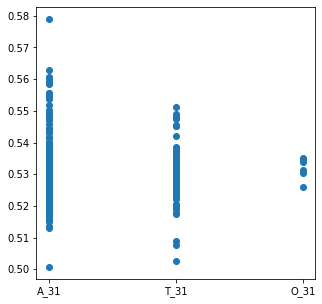

In [8]:
# scatterplot - relationship between
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(train_df['PRODUCT_CODE'], train_df['Y_Quality'])
plt.show()

### 1.1.1 Outliers

[outlier Dection: IsolationForest](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html)

In [9]:
xs = list(train_df.iloc[:, 6:].columns)

In [10]:
for col in xs: 
    q3 = train_df[col].quantile(0.95)
    median = train_df[col].quantile(0.50)

    train_df[col] = np.where(train_df[col]>q3, median, train_df[col])

train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,65.14,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,65.14,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,2.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,1.882521,95.123209,0.0,45.0,10.392550,0.0,48.212034,10.0,...,50.535850,53.173650,49.185100,51.507150,65.974400,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,0.322452,4.107640,0.0,0.0,0.489019,0.0,3.807249,0.0,...,6.792048,7.742964,6.775488,8.806132,3.586874,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,32.120000,31.700000,32.560000,30.490000,61.670000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,49.485000,52.200000,42.160000,49.915000,63.645000,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,53.412500,55.882500,51.445000,56.157500,65.140000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.0,...,55.007500,58.125000,54.482500,57.015000,66.800000,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,2.000000,102.000000,0.0,45.0,11.000000,0.0,57.000000,10.0,...,57.940000,61.840000,59.610000,58.790000,76.970000,1.0,NaN,NaN,NaN,NaN


### 1.1.2 Missing Value

In [12]:
# 1) features that have only 'NaN' without any recorded values 
## Total 81 features only have 'NaN' 
miss_dic = train_df.isnull().sum().to_dict()
all_NaN = pd.DataFrame({i for i in miss_dic if miss_dic[i]==598})
all_NaN_name = list(all_NaN[0])  # all_NaN features name in list 
len(all_NaN_name)

82

In [13]:
all_NaN2 = pd.DataFrame(np.zeros((82,82)), columns=list(all_NaN[0]))
all_NaN2

,X_2662,X_2678,X_2638,X_2684,X_2683,X_2838,X_2691,X_2648,X_2873,X_2694,...,X_2653,X_2659,X_2629,X_2673,X_2687,X_2635,X_2652,X_2668,X_2647,X_2657
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
for i in all_NaN_name: 
    train_df[i] = train_df[i].apply(lambda x: 0)

train_df.X_2686.isnull().sum()  # e.g. check whether or not it's perfectly fill with ZERO 

0

In [15]:
# 2) relace missing values with MEDIAN
train_df.fillna(train_df.median(), inplace=True)
train_df

<ipython-input-15-af1f9814f8ca>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.fillna(train_df.median(), inplace=True)


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,2.0,95.0,0.0,45.0,...,39.3400,40.8900,32.560,34.0900,65.14,1.0,0,0,0,0
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,2.0,95.0,0.0,45.0,...,38.8900,42.8200,43.920,35.3400,72.55,1.0,0,0,0,0
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,2.0,95.0,0.0,45.0,...,39.1900,36.6500,42.470,36.5300,65.14,1.0,0,0,0,0
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,2.0,95.0,0.0,45.0,...,37.7400,39.1700,52.170,30.5800,71.78,1.0,0,0,0,0
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,2.0,95.0,0.0,45.0,...,38.7000,41.8900,46.930,33.0900,76.97,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,2.0,95.0,0.0,45.0,...,49.4700,53.0700,50.890,55.1000,66.49,1.0,0,0,0,0
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,2.0,95.0,0.0,45.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,2.0,94.0,0.0,45.0,...,53.4125,55.8825,51.445,56.1575,65.14,1.0,0,0,0,0


In [16]:
# 3) check is there still any missing value in train_df
miss = train_df.isnull().sum().to_dict()
print({i for i in miss if miss[i] > 0})

set()


In [17]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.000000,598.0,598.000000,598.0,...,598.000000,598.000000,598.000000,598.000000,598.000000,598.0,598.0,598.0,598.0,598.0
mean,1.025084,0.530896,1.931438,95.071906,0.0,45.0,10.229097,0.0,46.874582,10.0,...,52.931455,55.429515,51.067090,55.379849,65.279532,1.0,0.0,0.0,0.0,0.0
std,0.565069,0.007401,0.252919,3.136725,0.0,0.0,0.420604,0.0,3.310709,0.0,...,2.967211,3.311438,2.885337,3.984516,1.493526,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,32.120000,31.700000,32.560000,30.490000,61.670000,1.0,0.0,0.0,0.0,0.0
25%,1.000000,0.527535,2.000000,94.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,53.412500,55.882500,51.445000,56.157500,65.140000,1.0,0.0,0.0,0.0,0.0
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,...,53.412500,55.882500,51.445000,56.157500,65.140000,1.0,0.0,0.0,0.0,0.0
75%,1.000000,0.533433,2.000000,95.000000,0.0,45.0,10.000000,0.0,50.000000,10.0,...,53.412500,55.882500,51.445000,56.157500,65.140000,1.0,0.0,0.0,0.0,0.0
max,2.000000,0.578841,2.000000,102.000000,0.0,45.0,11.000000,0.0,57.000000,10.0,...,57.940000,61.840000,59.610000,58.790000,76.970000,1.0,0.0,0.0,0.0,0.0


## 1.2 Test Set

In [ ]:
test_df

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,TEST_305,2022-11-05 11:18,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,TEST_306,2022-11-05 16:39,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,TEST_307,2022-11-05 16:47,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,TEST_308,2022-11-05 20:53,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP','Y_Class','Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID','TIMESTAMP'])

In [ ]:
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [ ]:
# qualitative to quantitative
qual_col = ['LINE','PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])

    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])
print('Done')

# 1. LINE과 PRODUCT_CODE를 기준으로 데이터를 봤을 때, 이상치 제거하고 결측치는 평균값 혹은 중간값 등으로 대체.
# 2. 열이 비어있는 경우(총 82개 열 존재)는 0으로 채우기 

Done


# 2.Training

## 2.1 Random Forest

In [ ]:
# RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
# print('Done')

Done


In [ ]:
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(train_x, train_y,
                                                                          test_size=0.25,
                                                                          random_state=37)

In [ ]:
train_labels

240    2
185    1
315    2
410    0
396    1
      ..
451    1
22     0
437    1
251    1
363    0
Name: Y_Class, Length: 448, dtype: int64

In [ ]:
model = RandomForestClassifier()

In [ ]:
fitted = model.fit(train_features, train_labels)

In [ ]:
print(fitted.score(train_features, train_labels))
print(fitted.score(val_features, val_labels))

1.0
0.7733333333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=37, shuffle=False)

# clf = RandomForestClassifier(max_depth=2, random_state=37)
# clf.fit(X,y)
# print(clf.predict([[0,0,0,0]]))

[0]


# Inference

In [ ]:
preds = RF.predict(test_x)
print('Done.')

Done.


In [ ]:
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

# Submit

In [ ]:
# submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

# submit['Y_Class'] = preds
# submit.to_csv('/content/drive/MyDrive/baseline_submission.csv', index=False)